# Import

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import os
import holidays


#Save requirements
os.system("pip freeze > requirements.txt")

#SEED   
np.random.seed(42)
tf.random.set_seed(42)

In [234]:
df = pd.read_csv('Data/london_merged.csv')
display(df.head(2))

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0


- Metadata:
  - "timestamp" - timestamp field for grouping the data
  - "cnt" - the count of a new bike shares
  - "t1" - real temperature in C
  - "t2" - temperature in C "feels like"
  - "hum" - humidity in percentage
  - "wind_speed" - wind speed in km/h
  - "weather_code" - category of the weather
  - "is_holiday" - boolean field - 1 holiday / 0 non holiday
  - "is_weekend" - boolean field - 1 if the day is weekend
  - "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.
  - "weathe_code" category description:
     - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
     - 2 = scattered clouds / few clouds 
     - 3 = Broken clouds 
     - 4 = Cloudy 
     - 7 = Rain/ light Rain shower/ Light rain 
     - 10 = rain with thunderstorm 
     - 26 = snowfall 
     - 94 = Freezing Fog

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Data Wrangling

In [236]:
#Convert the timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
#Keep records from 2015 and 2016
df = df[(df['timestamp'].dt.year == 2015) | (df['timestamp'].dt.year == 2016)]
#Sort the values by timestamp
df = df.sort_values('timestamp')

In [237]:
#Missing values
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

- No missing values. But there might be missing timestamps.

In [238]:
#Check for missing timestamps
all_days = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='h')
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 130


In [239]:
missing_days[0]

Timestamp('2015-01-07 19:00:00')

- 130 timestamps are missing. We will imput them using existing values.

In [240]:
#London holidays
uk_holidays = holidays.UK(years=[df['timestamp'].dt.year.min(), df['timestamp'].dt.year.max()])
uk_holidays

{datetime.date(2016, 3, 25): 'Good Friday', datetime.date(2016, 5, 2): 'May Day', datetime.date(2016, 5, 30): 'Spring Bank Holiday', datetime.date(2016, 1, 1): "New Year's Day", datetime.date(2016, 12, 25): 'Christmas Day', datetime.date(2016, 12, 27): 'Christmas Day (observed)', datetime.date(2016, 12, 26): 'Boxing Day', datetime.date(2015, 4, 3): 'Good Friday', datetime.date(2015, 5, 4): 'May Day', datetime.date(2015, 5, 25): 'Spring Bank Holiday', datetime.date(2015, 1, 1): "New Year's Day", datetime.date(2015, 12, 25): 'Christmas Day', datetime.date(2015, 12, 26): 'Boxing Day', datetime.date(2015, 12, 28): 'Boxing Day (observed)'}

In [241]:
#Create new dataframe using all days
df_full = pd.DataFrame(all_days, columns=['timestamp'])
#Merge with df to get cnt, t1, t2, hum, wind_speed, weather_code, season
df_full = df_full.merge(df[['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season']], on='timestamp', how='left')
#is_holiday column: 1 if holiday, 0 if not
df_full['is_holiday'] = np.where(df_full['timestamp'].dt.date.isin(uk_holidays), 1, 0)
df_full['is_weekend'] = np.where(df_full['timestamp'].dt.dayofweek.isin([5, 6]), 1, 0)

#Backfill missing values
df_full = df_full.ffill()
df = df_full.copy()

In [242]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
season          0
is_holiday      0
is_weekend      0
dtype: int64

In [243]:
missing_days = all_days[~all_days.isin(df['timestamp'])]
print('Number of missing timestamps:', len(missing_days))

Number of missing timestamps: 0


In [244]:
#Set the timestamp as the index
df.set_index('timestamp', inplace=True)
#Set period to 1 hour
df.index = pd.DatetimeIndex(df.index).to_period('h')
df.head(2)

,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04 00:00,182.0,3.0,2.0,93.0,6.0,3.0,3.0,0,1
2015-01-04 01:00,138.0,3.0,2.5,93.0,5.0,1.0,3.0,0,1


In [245]:
df = df.resample('D').agg({'cnt':'sum', 
                           't1':'median', 
                           't2':'median', 
                           'hum':'median', 
                           'wind_speed':'median', 
                           'weather_code': lambda x: x.value_counts().index[0], 
                           'season': lambda x: x.value_counts().index[0], 
                           'is_holiday':'max', 
                           'is_weekend':'max'})
df.head(2)

C:\Users\sbhurtyal\AppData\Local\Temp\ipykernel_25808\2112590929.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  df = df.resample('D').agg({'cnt':'sum',


,cnt,t1,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,,
2015-01-04,9234.0,2.75,0.00,93.0,7.0,3.0,3.0,0,1
2015-01-05,20372.0,9.00,7.25,81.5,8.5,3.0,3.0,0,0


In [246]:
#Remove duplicates
df.drop_duplicates(inplace=True)

Index(['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'season',
       'is_holiday', 'is_weekend'],
      dtype='object')
t1
t2
hum
wind_speed
weather_code
season
is_holiday
is_weekend


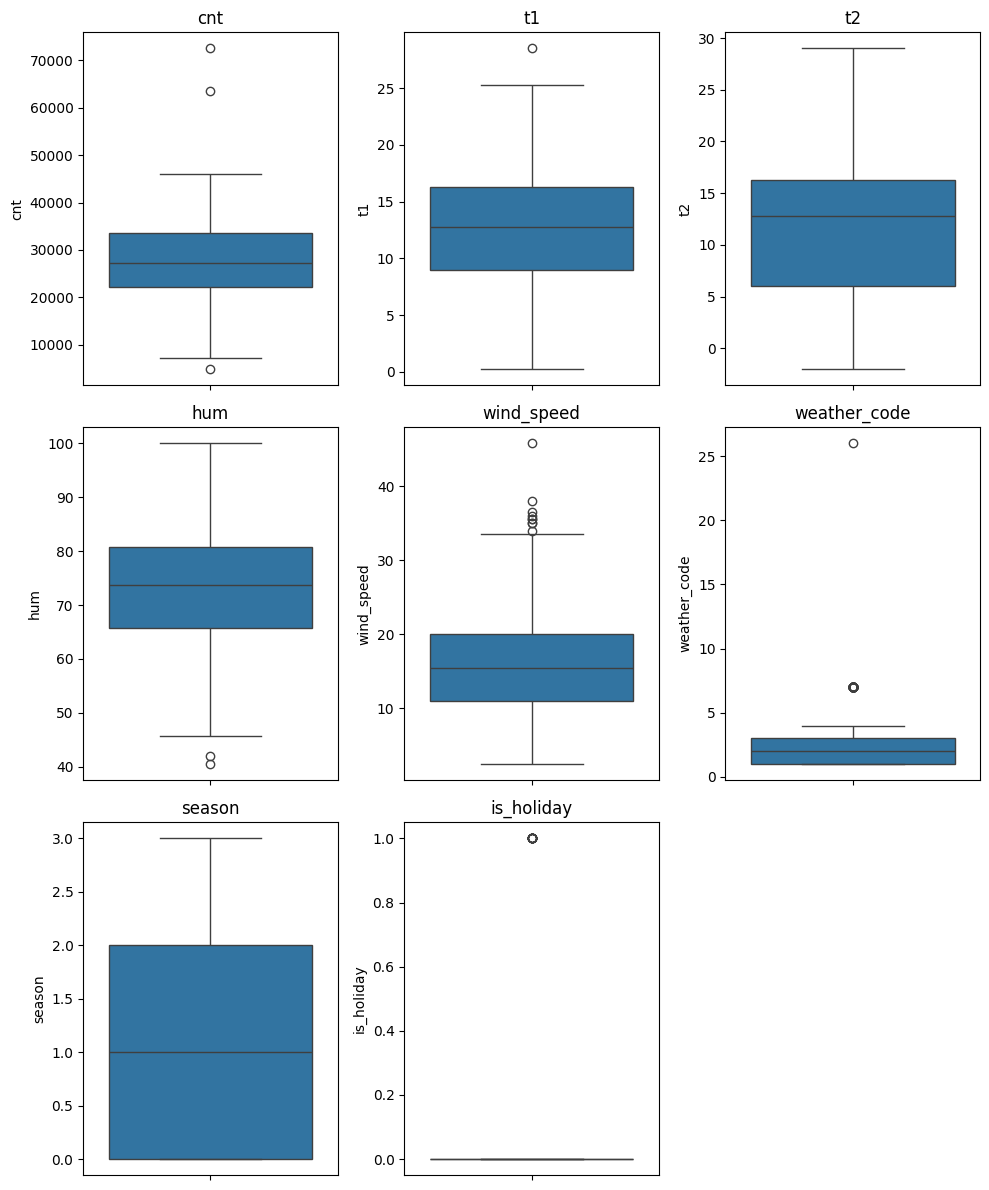

In [247]:
# # Boxplot of all the columns
plt.figure(figsize=(10, 12))
cols = df.columns
print(cols)
for i in range(1, len(cols)):
    print(cols[i])
    plt.subplot(3, 3, i)
    sns.boxplot(df[cols[i-1]])
    plt.title(cols[i-1])
plt.tight_layout()
plt.show()

- There is no abnormal data in the dataset.

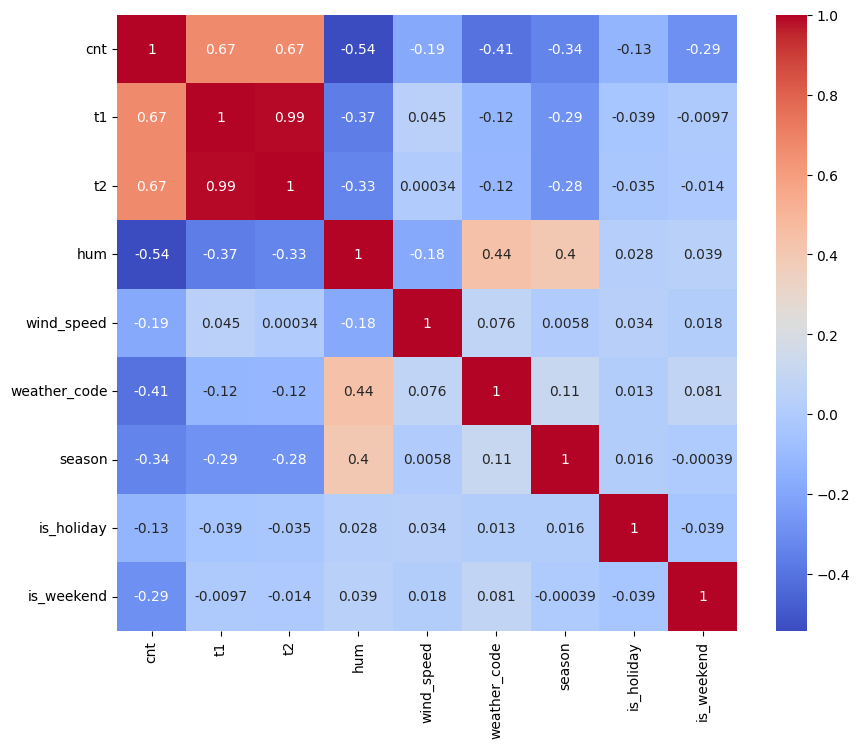

In [248]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

- Real and feels like temperature are highly correlated. Let's use feels like temperature since it is more likely to impact the decision.

In [249]:
#Drop t1
df.drop('t1', axis=1, inplace=True)

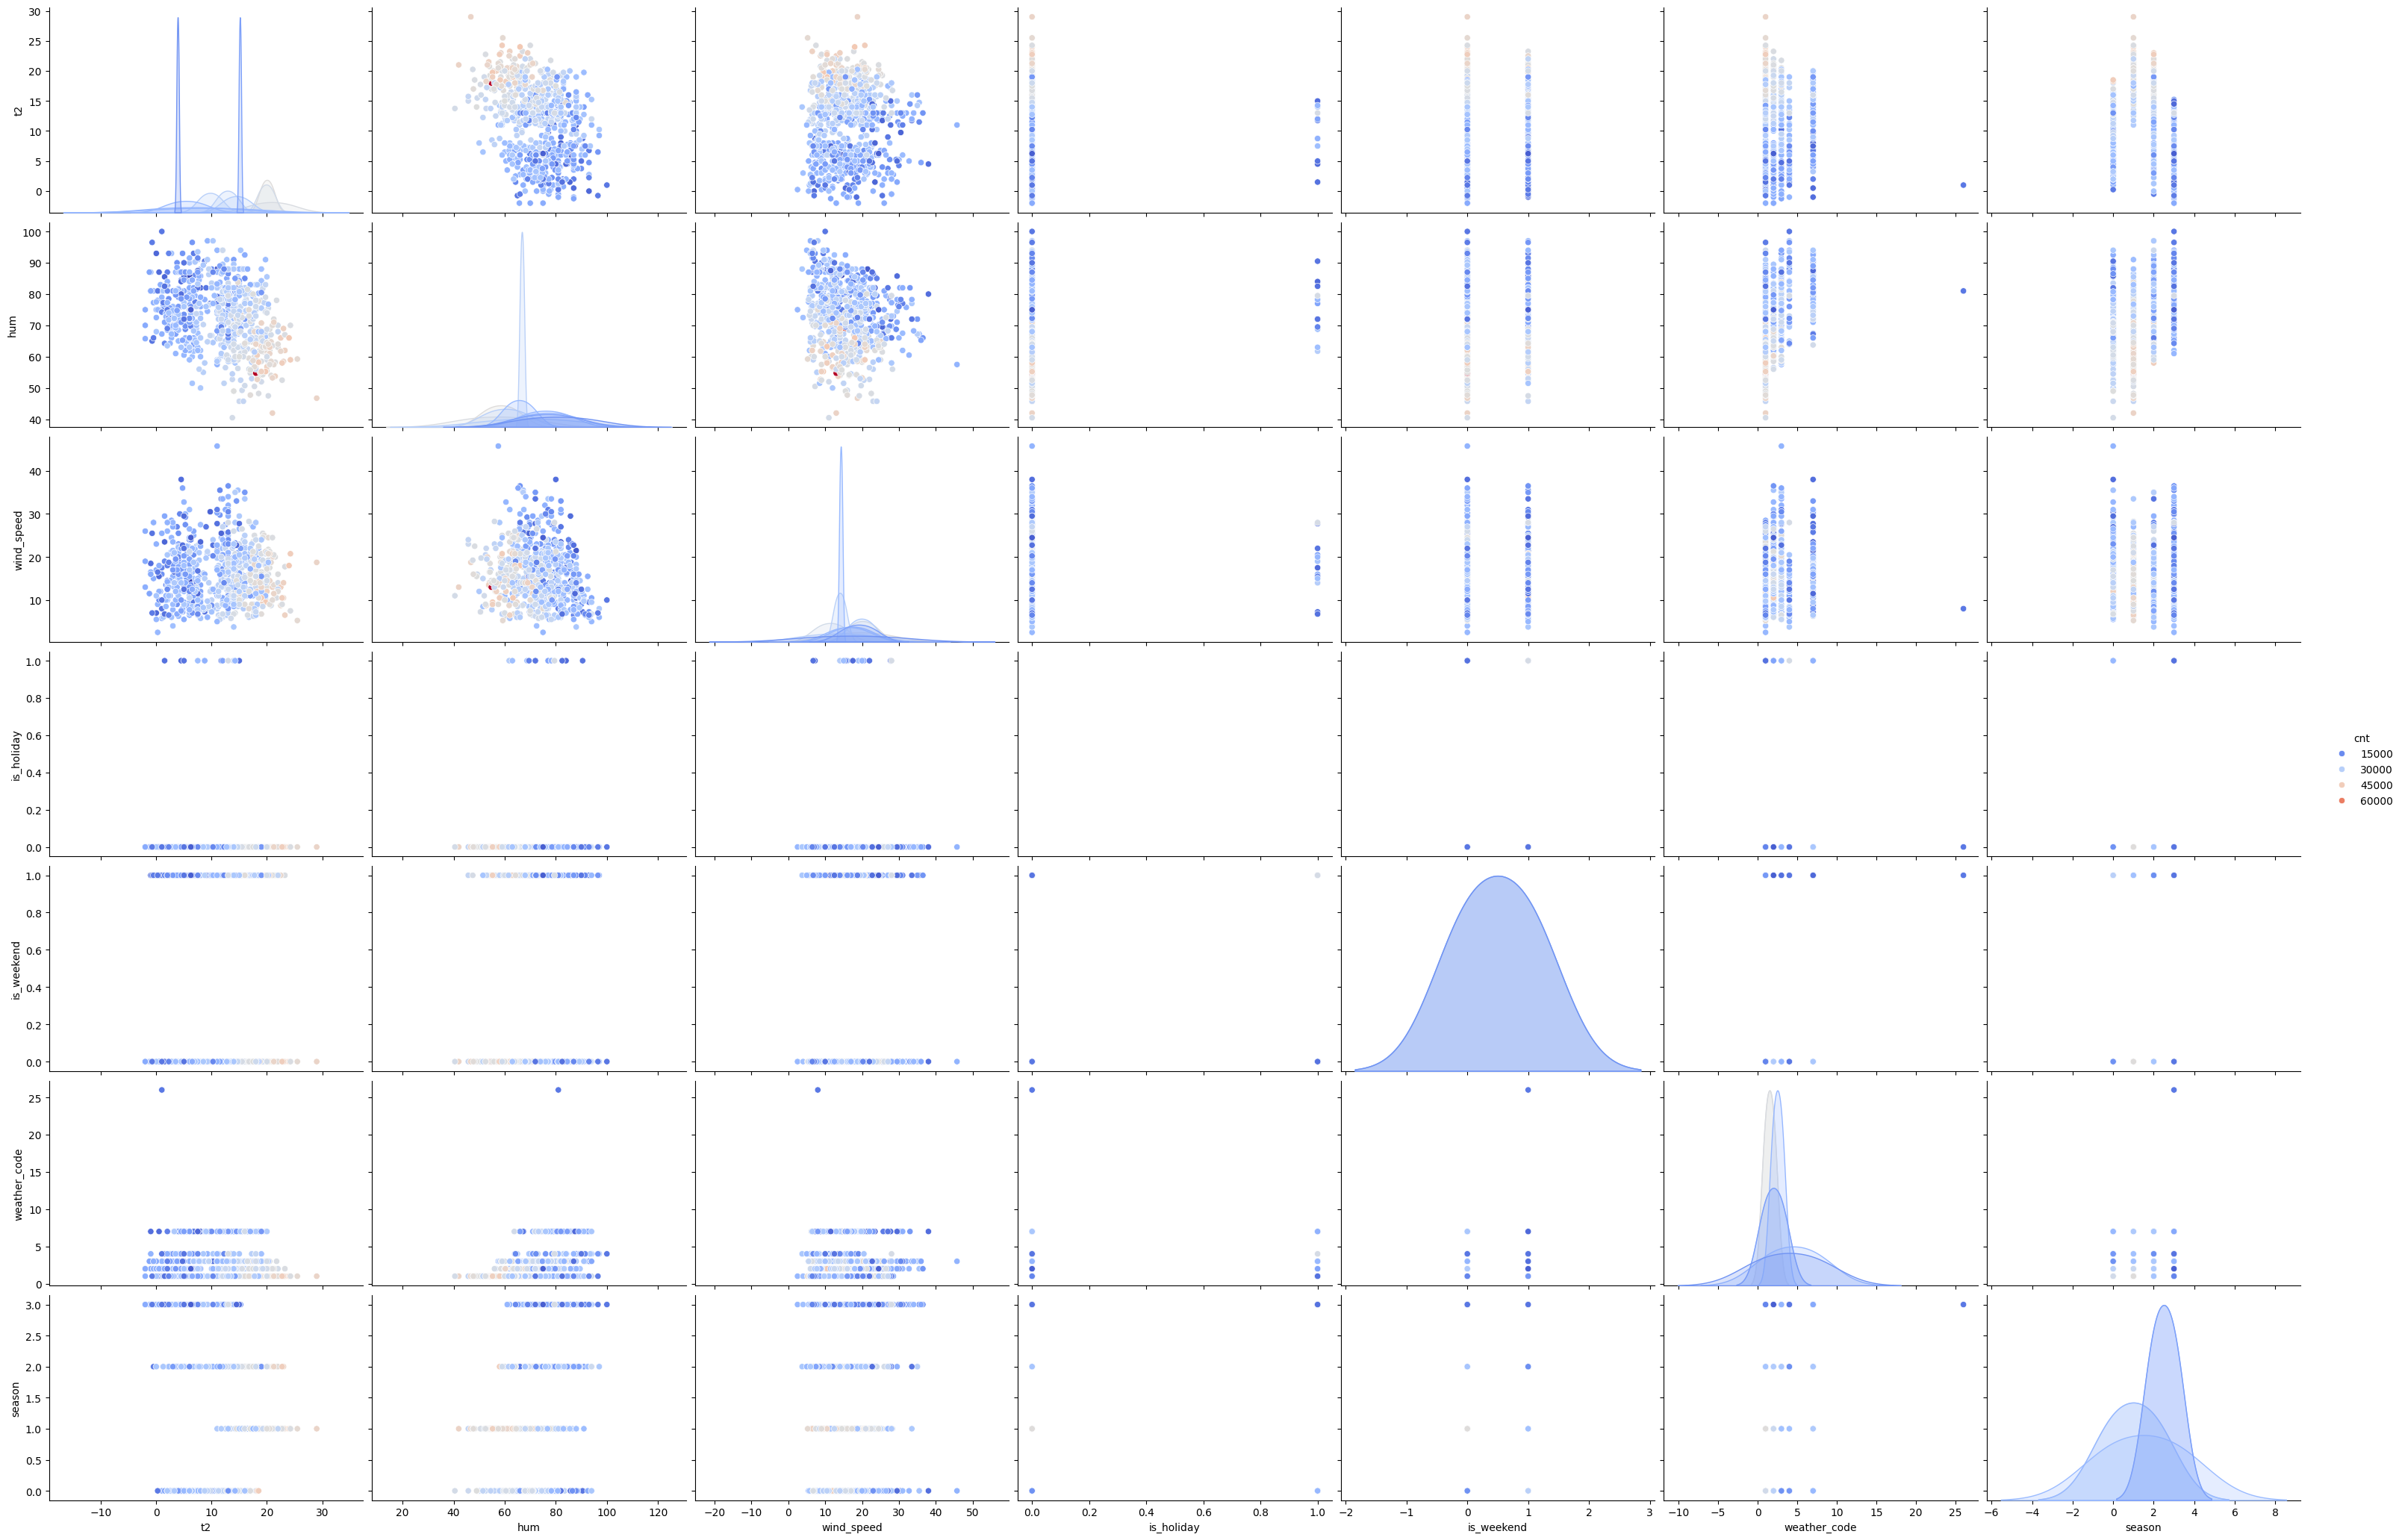

In [250]:
# #Pairplot
sns.pairplot(df[['cnt', 't2', 'hum', 'wind_speed', 'is_holiday', 'is_weekend', 'weather_code', 'season']],
             hue='cnt', 
             palette='coolwarm',
             height=3,
             aspect=1.5)
plt.show()

In [251]:
#Map codes
#Map weather code:
weather_desc = {
    1: 'Clear', 2: 'Scattered_Clouds', 3: 'Broken_Clouds', 4: 'Cloudy', 7: 'Rain', 10: 'Storm', 26: 'Snowfall', 94: 'Freezing_Fog'
}
df['weather_code'] = df['weather_code'].map(weather_desc)

#Map is_holiday:
df['is_holiday'] = df['is_holiday'].map({0:'No_Holiday', 1:'Holiday'})

#Map is_weekend:
df['is_weekend'] = df['is_weekend'].map({0:'Weekday', 1:'Weekend'})

#Map season:
seasons = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
df['season'] = df['season'].map(seasons)
df.head(2)

,cnt,t2,hum,wind_speed,weather_code,season,is_holiday,is_weekend
timestamp,,,,,,,,
2015-01-04,9234.0,0.00,93.0,7.0,Broken_Clouds,Winter,No_Holiday,Weekend
2015-01-05,20372.0,7.25,81.5,8.5,Broken_Clouds,Winter,No_Holiday,Weekday


In [252]:
#One hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True, dtype=int)
df.head(2)

,cnt,t2,hum,wind_speed,weather_code_Clear,weather_code_Cloudy,weather_code_Rain,weather_code_Scattered_Clouds,weather_code_Snowfall,season_Spring,season_Summer,season_Winter,is_holiday_No_Holiday,is_weekend_Weekend
timestamp,,,,,,,,,,,,,,
2015-01-04,9234.0,0.00,93.0,7.0,0,0,0,0,0,0,0,1,1,1
2015-01-05,20372.0,7.25,81.5,8.5,0,0,0,0,0,0,0,1,1,0


In [253]:
#Training df till June 2016 and testing df from July 2016
train_df = df.loc[:'2016-06-30'].copy()
test_df = df.loc['2016-07-01':].copy()

# Models

## SARIMAX

### Check Stationarity

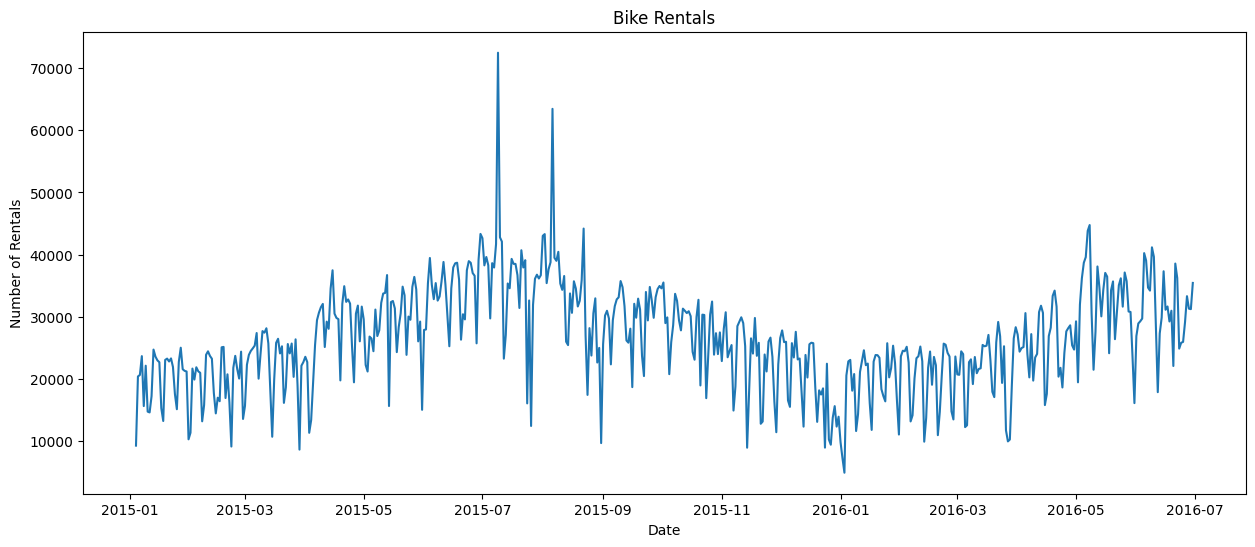

In [254]:
#Plot to check for stationarity
plt.figure(figsize=(15, 6))
plt.plot(train_df.index.to_timestamp(), train_df['cnt'])
plt.title('Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.show()

- There is no noticeable trend in the data. The data looks stationary. Let's verify this with the Augmented Dickey-Fuller test.

In [255]:
def check_stationarity(data):
    print('Null Hypothesis: Presence of unit root (Data is not stationary)')
    print('Alternate Hypothesis: Absence of unit root (Data is stationary)')
    result = adfuller(data, autolag='AIC')
    print(result)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print('Data is not stationary')
    else:
        print('Data is stationary')

check_stationarity(train_df['cnt'])

Null Hypothesis: Presence of unit root (Data is not stationary)
Alternate Hypothesis: Absence of unit root (Data is stationary)
(-2.134764140765682, 0.23076740880382357, 14, 529, {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}, 10503.323249600502)
ADF Statistic: -2.134764140765682
p-value: 0.23076740880382357
Data is not stationary


In [256]:
# Make data stationary
sarima_train_df = train_df.copy()
sarima_train_df.loc[:, 'cnt_diff'] = sarima_train_df['cnt'] - sarima_train_df['cnt'].shift(1)
sarima_train_df.dropna(inplace=True)
check_stationarity(sarima_train_df['cnt_diff'])

Null Hypothesis: Presence of unit root (Data is not stationary)
Alternate Hypothesis: Absence of unit root (Data is stationary)
(-8.879464818925591, 1.3300480462862018e-14, 19, 523, {'1%': -3.4429153652063986, '5%': -2.8670821452874007, '10%': -2.5697217608736187}, 10475.77169018873)
ADF Statistic: -8.879464818925591
p-value: 1.3300480462862018e-14
Data is stationary


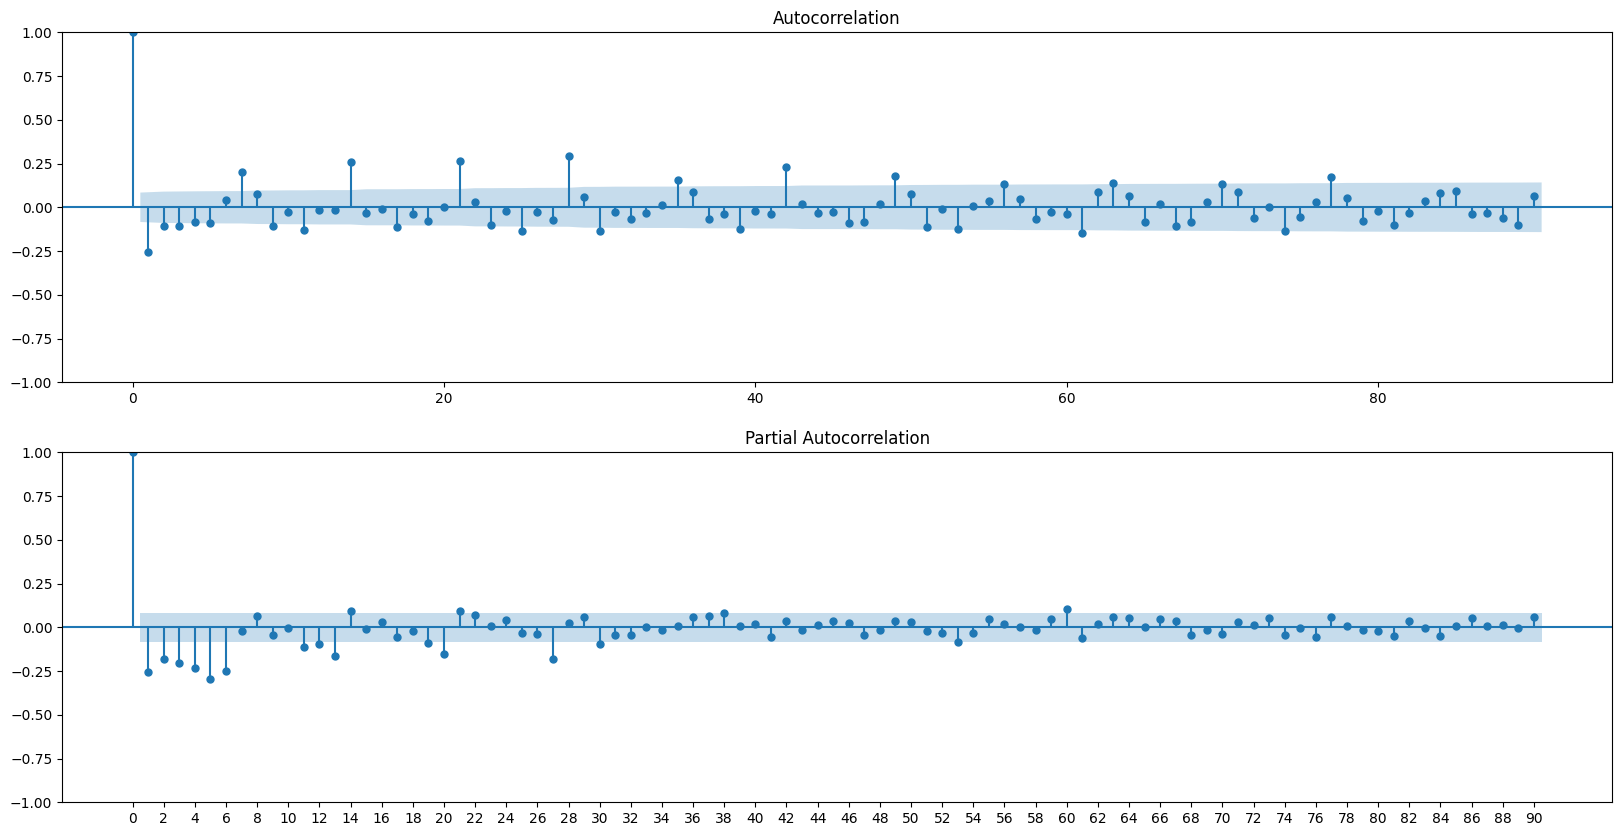

In [257]:
# #ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20, 10))
plt.subplot(211)
plot_acf(sarima_train_df['cnt_diff'], lags=90, ax=plt.gca())
plt.subplot(212)
plot_pacf(sarima_train_df['cnt_diff'], lags=90, ax=plt.gca())
plt.xticks(np.arange(0, 91, 2))
plt.show()

- Estimating AR terms: The PACF plot shows a significant spike at lag 1 to 6. Therefore, p = 6.
- Estimating I term: We have made the data stationary. Therefore, d = 0.
- Estimating MA terms: The ACF plot shows a significant spike at lag 1, 2, 3. Therefore, q = 3.
- Estimating seasonal AR terms: The PACF plot shows a significant spike at lag 29. Therefore, P = 1.
- Estimating seasonal I term: We have made the data stationary. Therefore, D = 0.
- Estimating seasonal MA terms: The ACF plot shows a significant spike at five 7 days. Therefore, Q = 5.
- ACF plot shows strong correlation at lag 7's. Therefore, s = 7. 

In [283]:
#Auto ARIMA
model = auto_arima(train_df['cnt'],
                    X=train_df.drop(['cnt'], axis=1),
                    start_p=0,
                    d=1,
                    start_q=0,
                    max_p=6,
                    max_d=1,
                    max_q=5,
                    start_P=1,
                    D=1,
                    start_Q=1,
                    s=7,
                    max_P=5,
                    max_D=1,
                    max_Q=5,
                    stationary=True,
                    n_jobs=5,
                    stepwise = False,
                    random=True,
                    random_state=42,
                    scoring='mae',
                    maxiter=1000,
                     )
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  544
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5328.144
Date:                Thu, 11 Jul 2024   AIC                          10692.288
Time:                        17:02:30   BIC                          10769.669
Sample:                    01-04-2015   HQIC                         10722.541
                         - 06-30-2016                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
intercept                       657.3940    548.678      1.198      0.231    -417.994    1732.782
t2                              570.6598     69.554      8.205      0.000 

In [284]:
#Print best parameters
print('Best parameters:', model.get_params())

Best parameters: {'maxiter': 100, 'method': 'lbfgs', 'order': (1, 0, 2), 'out_of_sample_size': 0, 'scoring': 'mae', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 1), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': True}


In [285]:
sarima_train_df.head()

,cnt,t2,hum,wind_speed,weather_code_Clear,weather_code_Cloudy,weather_code_Rain,weather_code_Scattered_Clouds,weather_code_Snowfall,season_Spring,season_Summer,season_Winter,is_holiday_No_Holiday,is_weekend_Weekend,cnt_diff
timestamp,,,,,,,,,,,,,,,
2015-01-05,20372.0,7.25,81.50,8.5,0,0,0,0,0,0,0,1,1,0,11138.0
2015-01-06,20613.0,5.75,79.75,15.0,1,0,0,0,0,0,0,1,1,0,241.0
2015-01-07,23643.0,5.75,81.00,22.5,0,0,0,1,0,0,0,1,1,0,3030.0
2015-01-08,15601.0,6.75,79.50,20.5,0,0,1,0,0,0,0,1,1,0,-8042.0
2015-01-09,22104.0,13.00,75.75,32.0,0,0,0,0,0,0,0,1,1,0,6503.0


RMSE: 5468.452878166889
MAE: 4200.889275346815
R2: 0.6123948333082698


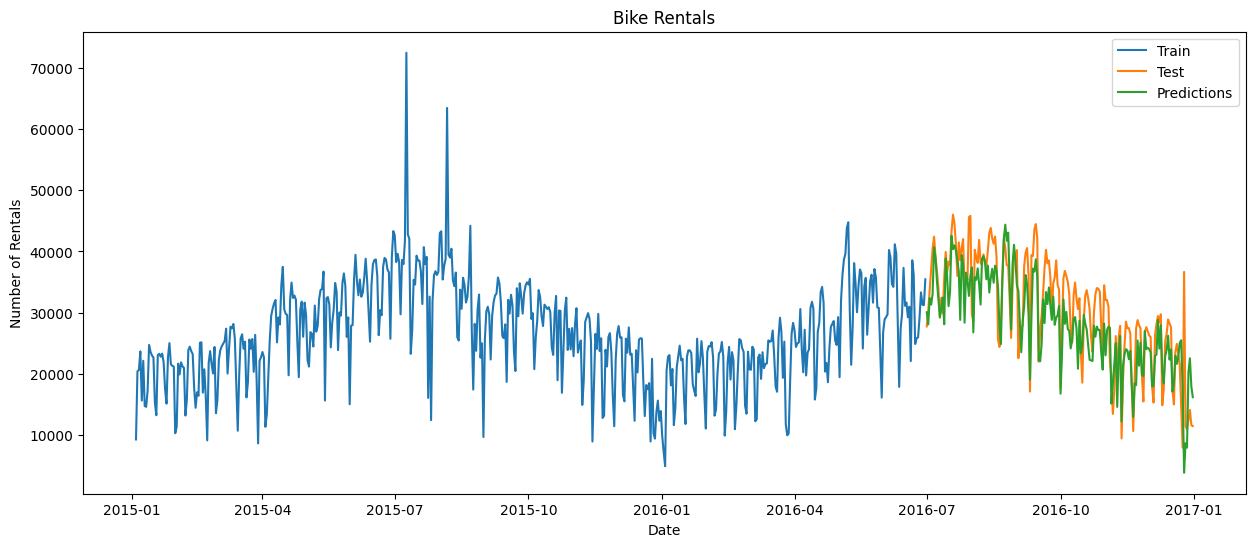

In [286]:
#Predictions
y_pred = model.predict(n_periods=len(test_df), X=test_df.drop('cnt', axis=1))

#RMSE, MAE, R2
rmse = np.sqrt(np.mean((y_pred - test_df['cnt'])**2))
mae = np.mean(np.abs(y_pred - test_df['cnt']))
r2 = 1 - (np.sum((test_df['cnt'] - y_pred)**2) / np.sum((test_df['cnt'] - test_df['cnt'].mean())**2))
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)

#Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(train_df.index.to_timestamp(), train_df['cnt'], label='Train')
plt.plot(test_df.index.to_timestamp(), test_df['cnt'], label='Test')
plt.plot(test_df.index.to_timestamp(), y_pred, label='Predictions')
plt.title('Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()


# Linear Regression

In [ ]:
#Linear regression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']
X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

X_train = add_constant(X_train)
X_test = add_constant(X_test)

lr = OLS(y_train, X_train)
lr = lr.fit()

#MAE, RMSE, R2
y_pred = lr.predict(X_test)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = lr.rsquared
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)

# XGBoost

In [ ]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']
X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.01, random_state=42)
model.fit(X_train, y_train)

#MAE, RMSE, R2
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = model.score(X_test, y_test)
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)

# Prophet

In [ ]:
#Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

pr_train = train_df.copy()
pr_train = pr_train.reset_index()
pr_train['timestamp'] = pr_train['timestamp'].dt.to_timestamp()
pr_train = pr_train.rename(columns={'timestamp':'ds', 'cnt':'y'})

pr_test = test_df.copy()
pr_test = pr_test.reset_index()
pr_test['timestamp'] = pr_test['timestamp'].dt.to_timestamp()
pr_test = pr_test.rename(columns={'timestamp':'ds', 'cnt':'y'})


model = Prophet()

model.add_regressor('t2')
model.add_regressor('hum')
model.add_regressor('wind_speed')
model.add_regressor('is_holiday_No_Holiday')
model.add_regressor('is_weekend_Weekend')
model.add_regressor('weather_code_Clear')
model.add_regressor('weather_code_Cloudy')
model.add_regressor('weather_code_Rain')
model.add_regressor('weather_code_Scattered_Clouds')
model.add_regressor('weather_code_Snowfall')
model.add_regressor('season_Summer')
model.add_regressor('season_Winter')

model.fit(pr_train)

#Predictions
future = model.make_future_dataframe(periods=len(pr_test), freq='D')
future = future.merge(pr_test[['ds', 't2', 'hum', 'wind_speed', 'is_holiday_No_Holiday', 'is_weekend_Weekend', 'weather_code_Clear', 'weather_code_Cloudy', 'weather_code_Rain', 'weather_code_Scattered_Clouds', 'weather_code_Snowfall', 'season_Summer', 'season_Winter']], on='ds', how='left')
future.dropna(inplace=True)
forecast = model.predict(future)

#MAE, RMSE, R2
mae = np.mean(np.abs(pr_test['y'] - forecast['yhat']))
rmse = np.sqrt(np.mean((pr_test['y'] - forecast['yhat'])**2))
r2 = 1 - np.sum((pr_test['y'] - forecast['yhat'])**2) / np.sum((pr_test['y'] - pr_test['y'].mean())**2)
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)

# Random Forest

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']
X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

model = RandomForestRegressor(n_estimators=4000, max_depth=10, random_state=42)
model.fit(X_train, y_train)

#MAE, RMSE, R2
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = model.score(X_test, y_test)
print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)

In [ ]:
#Data frame of pred and actual values
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
#Plot of actual vs predicted values
pred_df = pred_df.reset_index()
fig =plt.figure(figsize=(15, 6))
#Remove period
pred_df['timestamp'] = pred_df['timestamp'].dt.to_timestamp()
plt.plot(pred_df['timestamp'], pred_df['Actual'], label='Actual')
plt.plot(pred_df['timestamp'], pred_df['Predicted'], label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()